In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
import scipy.signal
import networkx as nx
import pandas as pd

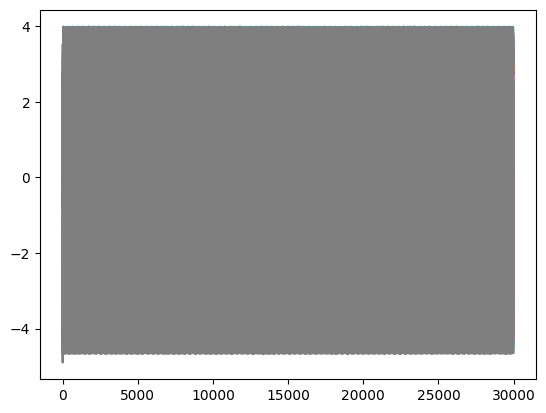

In [2]:

data = np.loadtxt("./ex5_files/TS_25.dat")
plt.plot(data)
plt.show()

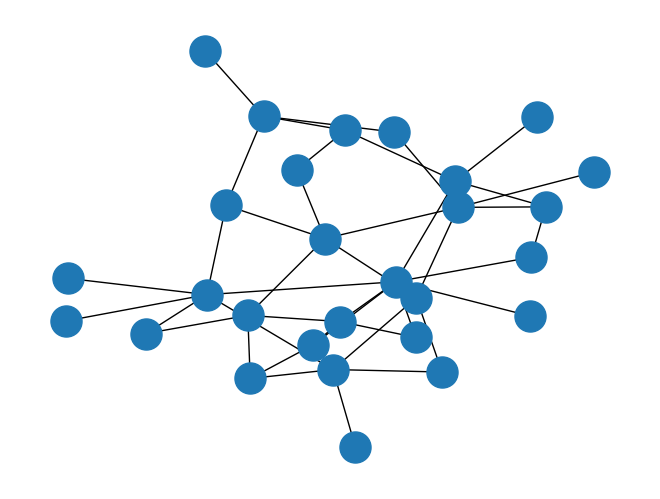

In [3]:
adj_mat = pd.read_csv('./ex5_files/Topology.dat', delim_whitespace=True, header=None)
rows, cols = np.where(adj_mat == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=500)
plt.show()

Calculate the degree distribution of the structural network:


[6.0, 7.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


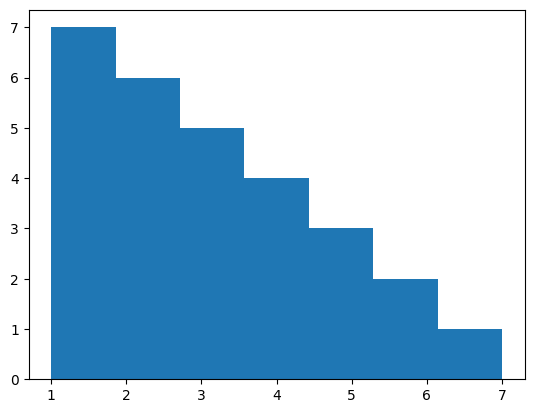

In [4]:
print(degrees := [sum(adj_mat[i]) for i in range(28)])
plt.hist(degrees, 7)
plt.show()

In [5]:
def pearson(s1, s2, lag=0) -> float:
    N = len(s1)
    return 1/(N-lag) * abs(sum([s1[k+lag] * s2[k] for k in range(1, N+lag)]))

Now we want to standardize the time series so that std(ts) = 1 and mean(ts) = 0:

In [101]:
def pearson_table_from_file(number: int):
    file_path = f"./ex5_files/TS_{str(number).zfill(2)}.dat"
    db = np.transpose(np.loadtxt(file_path))
    size = np.size(db, 0)
    table = np.empty((28,28))
    db1 = [(db[i] - np.mean(db[i]))/np.std(db[i]) for i in range(size)] #Standardizes the time series data column-wise
    column_indices = np.hstack([[i for i in range(0,j)] for j in range(1,28)])
    row_indices = np.hstack([[i]*i for i in range(1,28+1)])
    for row, col in zip(row_indices, column_indices):
        table[row, col] = pearson(db1[row], db1[col])
    return table
    #Combinatorically calculates the pearson coefficient and returns the lower triangle of a 28*28 matrix

b = pearson_table_from_file(5)
print(b)

[[0.00000000e+000 2.21393338e-314 0.00000000e+000             nan
  3.69845027e-057 1.51764595e-047 3.85582657e-086 9.66176391e-092
  5.88460073e-062 1.40007924e-076 9.95479005e-043 1.57610082e-052
  8.21688350e-072 2.13417542e-264 4.08298033e-033 1.65582597e-047
  3.67059524e-062 3.62661803e-086 1.16839995e-067 2.26064847e-264
  1.17661074e-047 1.65502414e-047 8.96902775e-067 3.25259727e-086
  9.66326211e-092 2.00561651e-076 1.39871935e-076 2.17731992e-076]
 [7.00231842e-001 5.38502239e-067 3.00351245e-264 1.14350575e-071
  5.88267557e-062 2.90739284e-033 3.42551695e-086 9.67077024e-092
  8.24023893e-067 5.05232077e-038 5.14868294e-062 3.25259719e-086
  9.66476016e-092 4.85560634e-033 7.71451192e-043 1.91554132e-076
  5.60005804e-067 8.21687920e-072 3.00497567e-264 4.76650533e-038
  9.17546446e-072 4.43690338e-038 3.52911898e-062 3.00448159e-264
  8.60605397e-043 4.08148455e-033 9.05971068e-043 1.57630473e-052]
 [8.39937947e-001 8.74533435e-001 5.05921296e-038 1.13000570e-042
  6.1248

In [102]:
all_raw_data = [pearson_table_from_file(k) for k in range(25)]

This calculates a heatmap for every measurement. This is akin to 25 x-y-heatmaps stacked on top of each other in the z-axis. We now want to merge this flatten this stack by averaging the cell values along the z-axis:

In [104]:
heatmap_data = np.mean(all_raw_data, axis=0)
print(np.matrix(heatmap_data))

[[0.00000000e+000 5.21690426e-078 3.05675562e-310             nan
  1.40122287e-034 1.16299792e-034 1.94104118e-034 2.02059759e-039
  2.79660100e-034 1.16278562e-034 2.71775064e-034 3.03681770e-034
  6.67915251e-034 7.07353224e-034 1.78756389e-034 3.26401701e-034
  4.81618529e-034 3.57603412e-034 2.64920170e-034 1.32478522e-034
  1.78696913e-034 3.26517463e-034 1.55466213e-034 1.16280667e-034
  1.78789562e-034 7.34659741e-039 4.15045665e-039 7.71454069e-039]
 [8.09004825e-001 4.42968393e-034 2.95188230e-034 1.48064022e-034
  1.24773743e-034 2.72721913e-039 1.77434024e-039 2.56534730e-034
  1.16328533e-034 4.63199914e-039 4.04375844e-039 1.40179159e-034
  1.16328414e-034 4.82140312e-034 4.97634600e-034 3.18940639e-034
  6.45812101e-034 1.78761369e-034 4.26566914e-039 4.65999597e-034
  3.26697667e-034 1.86554901e-034 4.67177755e-034 1.71147818e-034
  2.79696682e-034 2.96042619e-034 3.26550177e-034 4.03764855e-034]
 [6.93903820e-001 7.34612370e-001 3.54985038e-039 5.45392363e-039
  2.0237

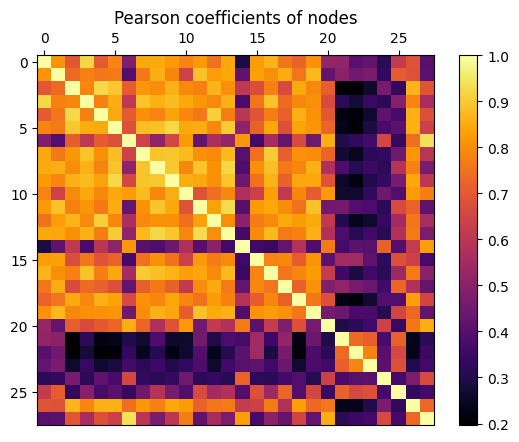

In [107]:
shaped_data = (np.tril(heatmap_data) + np.triu(heatmap_data.T, 1)) + np.identity(28)

fig, ax = plt.subplots()
im = ax.imshow(shaped_data, cmap='inferno', aspect='auto')

# Show all ticks and label them with the respective list entries
ax.xaxis.tick_top()
ax.set_title("Pearson coefficients of nodes")
fig.colorbar(im)
plt.show()

Reconstruct the network using the Pearson coefficient as a statistical similarity measure, keeping only the 10% strongest links:

In [133]:
# Flatten the matrix and sort in descending order
flattened = heatmap_data.flatten()
sorted_indices = np.argsort(flattened)[::-1]  # Reverse order to get highest values first

num_elem = 27*28/2 # Equal to 1+2+3+...+26+27
num_top_values = int((num_elem * 0.1))

# Get the indices of the top 10% highest values
top_10p_indices = np.unravel_index(sorted_indices[:num_top_values], heatmap_data.shape)
print(top_10p_indices)



(array([ 0, 27, 13,  9,  4,  3, 13, 12, 16, 13,  5,  9, 13,  9, 11,  7,  8,
       11, 19, 16,  8, 16,  7, 10,  9, 13, 16, 19, 12, 26, 16, 16, 19, 26,
       19, 18, 13]), array([ 3,  6, 11,  5,  2,  0,  8,  4,  7,  5,  2,  8,  9,  7,  8,  3,  7,
        1, 11,  3,  5,  8,  5,  7,  3,  7, 13,  1,  2,  2,  9,  0,  8,  4,
       13,  4,  3]))


Recalculate the correlation matrix with the top 10% strongest connections:

(37, 2)


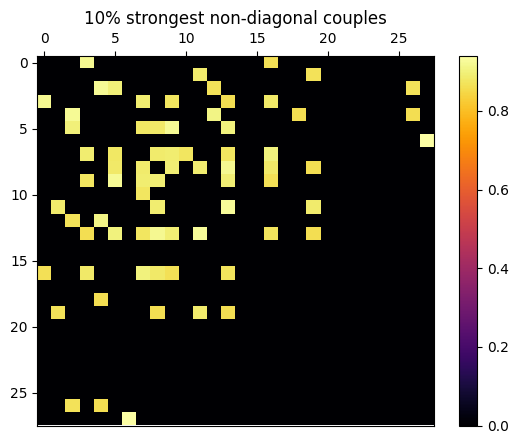

In [141]:

removed_heatmap_data = np.copy(heatmap_data)
row_indices = np.hstack([[i]*i for i in range(1,28+1)])
column_indices = np.hstack([[i for i in range(0,j)] for j in range(1,28)])
print(np.array(top_10p_indices).T.shape)
for row, col in zip(row_indices, column_indices):
    if [row, col] not in list(map(list, zip(*top_10p_indices))):
        removed_heatmap_data[row][col] = 0

shaped_data = (np.tril(removed_heatmap_data) + np.triu(removed_heatmap_data.T, 1)) 

fig, ax = plt.subplots()
im = ax.imshow(shaped_data, cmap='inferno', aspect='auto')

# Show all ticks and label them with the respective list entries
ax.xaxis.tick_top()
ax.set_title("10% strongest non-diagonal couples")
fig.colorbar(im)
plt.show()

In [13]:
print(np.mean(db1[0]))

7.342274936187702e-17


In [11]:
print(220*15)

3300
